# Generate training data

256×169 samples</p>
### Change demand
timestep = 1h, 1 week ->169 timesteps in total</p>
at every timestep, change the nodal demand</p>
### Change topology
Randomly cut the connectivity between two pipes, but preserving the connectivity between each node in the network and source. ->256 topology

### Try single timestep

In [1]:
import wntr
import networkx as nx
import scipy.sparse as sp
import numpy as np 
import random
import tqdm
import os 
import matplotlib.pyplot as plt
import itertools
from collections import Counter 
import networkx as nx
import copy
import pandas as pd
import tensorflow_gnn as tfgnn
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [5]:
def get_removable_links(inp_file):
    wn = wntr.network.WaterNetworkModel(inp_file)
    removable_links = []
    G = wn.to_graph(wn)
    # Store not-deadend pipes to be removed
    for _, link in wn.links():
        if (link.link_type == 'Pipe' and
            link.start_node.node_type == 'Junction' and
            link.end_node.node_type == 'Junction' and
            G.degree[link.start_node.name] > 1 and
            G.degree[link.end_node.name] > 1):
            removable_links.append(link)
    # To find pairs of links that can be removed together while keeping the network graph connected
    removable_pairs = []
    for (link1, link2) in itertools.combinations(removable_links, 2):
        wnr = copy.deepcopy(wn)  #create a new reference to the same object
        wnr.remove_link(link1)
        wnr.remove_link(link2)
        Gr = wnr.to_graph().to_undirected()
        if nx.is_connected(Gr):
            removable_pairs.append((link1, link2))

    return removable_links, removable_pairs


In [6]:
network = 'ASnet2'
inp_file = network + '.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# get removable links
removable_links, removable_pairs = get_removable_links(inp_file)
num_nodes = wn.num_nodes
num_links = wn.num_links
#num_time = 169
num_time = int(wn.options.time.duration / wn.options.time.report_timestep + 1)

In [4]:
start_value = 0
end_value = 604800
interval = 3600
Time_step = np.arange(start_value, end_value + 1, interval)
print(Time_step.size)

169


In [5]:
n_sims = 128
#𝑉_𝑖=[ 𝐼_𝑖^𝑑, 𝑞_𝑖, 𝐼_𝑖^𝑚,𝐻_𝑖^∗ ] 
#𝐸_𝑝=[𝑖,𝑗,𝑐_𝑝]
#Create data matrix
A = np.zeros((n_sims , num_links*num_time, 3))
B = np.zeros((n_sims , num_nodes*num_time, 6))
U = np.zeros((n_sims , num_nodes*num_time, 1))



# Store the randomly chosen pairs of removable links
links2remove = random.sample(removable_pairs, n_sims)

## Measurement when fully-supervised
measurement_fully = []
monitor = ['5', '11', '32', '37', '44']

In [7]:
for sim in range(n_sims):
    wn = wntr.network.WaterNetworkModel(inp_file)  # reset value
    wn.options.hydraulic.demand_model = 'DD' #dynamic demand model

    i = 0
    for _, node in wn.nodes():
        node.id = i
        i += 1

    if sim != 0:
        (link1, link2) = links2remove[sim - 1]
        wn.remove_link(link1)
        wn.remove_link(link2)

    i = 0
    for _, link in wn.links():
        A[sim, i, 0] = link.start_node.id
        A[sim, i, 1] = link.end_node.id
        if link.link_type=='Pipe':
            A[sim, i, 2] = 1/(10.667*link.length/link.roughness**1.852/link.diameter**4.871)
            i+=1
        elif link.link_type=='Pump':
            A[sim, i, 2] = 1        
        elif link.link_type=='Valve':
            A[sim, i, 2] = 2        
        else:
            print('Other types of links exist.')
        i+=1

    results = wntr.sim.EpanetSimulator(wn).run_sim(version=2.0)
    head = results.node['head']
    demand = results.node['demand']
    flow = results.link['flowrate']
    headloss = results.link['headloss']
    demand = np.maximum(demand, 0)
    
    ### Produce datas for multiple timestep
    #### Time step
    index_values = head.index.values
    #np.random.seed(42)
    #Time_step = np.random.choice(index_values, size=num_time, replace=False)
    
    repeated_timestep = pd.Series(Time_step).repeat(num_nodes).reset_index(drop=True)
    Time_indicator = pd.DataFrame({'Timestep': repeated_timestep})
    Time_indicator = Time_indicator.squeeze()
    
    #### Demand
    demand_s = demand.loc[Time_step]
    demand_s = demand_s.values.flatten()
    #### Head
    head_s = head.loc[Time_step]
    head_s = head_s.values.flatten()
    #### Flow
    flow_s = flow.loc[Time_step]
    flow_s = flow_s.values.flatten()
    #### Headloss
    hl_s = headloss.loc[Time_step]
    hl_s = hl_s.values.flatten()
    
    #### Node indicator (the number of the node)
    Node_indicator = np.tile(np.arange(1, num_nodes+1), num_time)
        # Measurement when fully-supervised
    measurement_fully = Node_indicator
    #### Junction indicator (if the node is not a reservoir, junction indicator = 1)
    Nd_single = np.array([1 if node.node_type == 'Junction' else 0 for _, node in wn.nodes()])
    Nd = np.tile(Nd_single,num_time)
    Nd = Nd.squeeze()
    #### Measurement indicator (if the node has head, measurement indicator = 1) (fully-supervised, all 1)
    Nh_single = np.zeros(num_nodes)
    Nh = np.tile(Nh_single,num_time)
    Nh = Nh.squeeze()
    
    ### Node
    B[sim, :, 0] = Time_indicator
    B[sim, :, 1] = Node_indicator
    B[sim, :, 2] = Nd
    B[sim, :, 3] = demand_s
    B[sim, :, 4] = Nh
    B[sim, :, 5] = (1 - Nh) * head_s
    ###

    U[sim, :, 0] = head_s

In [8]:
### Edge
A_re = A[:, :num_links, :]  # Extract the first 65 rows along the second axis

# Repeat the 65 rows to cover the entire second axis
A_re = np.tile(A_re, (1, num_time, 1))


### Change 3-d array to DataFrame

In [33]:
array_3d_shape = B.shape
new_shape = (array_3d_shape[0]* array_3d_shape[1] ,array_3d_shape[2])

# Reshaping the 3-dimensional array into a 2-dimensional array
B_2d = B.reshape(new_shape)

# Converting the 2-dimensional array into a DataFrame
node_df = pd.DataFrame(B_2d)

array_3d_shape = A_re.shape
new_shape = (array_3d_shape[0]* array_3d_shape[1] ,array_3d_shape[2])

# Reshaping the 3-dimensional array into a 2-dimensional array
A_2d = A_re.reshape(new_shape)

# Converting the 2-dimensional array into a DataFrame
edge_df = pd.DataFrame(A_2d)

array_3d_shape = U.shape
new_shape = (array_3d_shape[0]* array_3d_shape[1] ,array_3d_shape[2])

# Reshaping the 3-dimensional array into a 2-dimensional array
U_2d = U.reshape(new_shape)

# Converting the 2-dimensional array into a DataFrame
graph_df = pd.DataFrame(U_2d)

In [34]:
graph_df.rename(columns={0: 'head'},inplace=True)
edge_df.rename(columns={0: 'source', 1: 'target', 2: 'loss_co',3:'flowrate'},inplace=True)
node_df.rename(columns={0:'Time_indicator', 1: 'Node_indicator', 2:'Junction_in',3: 'demand', 4: 'Measurement_in',5:'measurement'},inplace=True)

## Scale the data

In [15]:
# Edge
# Column names to scale
column_to_scale = ['loss_co']

# Create a StandardScaler object
scaler = StandardScaler()

# Fit and transform the selected columns
edge_df[column_to_scale] = scaler.fit_transform(edge_df[column_to_scale])

# Node
## Create a StandardScaler object
scaler = StandardScaler()

## Select the column to scale
columns_to_scale = ['demand', 'measurement']

# Fit and transform the selected columns
node_df[columns_to_scale] = scaler.fit_transform(node_df[columns_to_scale])
#


# Graph
## Create a StandardScaler object
scaler = StandardScaler()

## Select the column to scale
columns_to_scale = ['head']

# Fit and transform the selected columns
graph_df[columns_to_scale] = scaler.fit_transform(graph_df[columns_to_scale])

In [16]:
test_edge_df = edge_df[n_sims * num_links * (num_time - 34):]
test_node_df = node_df[n_sims * num_nodes * (num_time - 34):]
test_graph_df = graph_df[n_sims * num_nodes * (num_time - 34):]

train_edge_df = edge_df[:n_sims * num_links * (num_time - 100)]
train_node_df = node_df[:n_sims * num_nodes * (num_time - 100)]
train_graph_df = graph_df[:n_sims * num_nodes * (num_time - 100)]

vali_edge_df = edge_df[n_sims * num_links * (num_time - 67):n_sims * num_links * (num_time - 34)]
vali_node_df = node_df[n_sims * num_nodes * (num_time - 67):n_sims * num_nodes * (num_time - 34)]
vali_graph_df = graph_df[n_sims * num_nodes * (num_time - 67):n_sims * num_nodes * (num_time - 34)]

In [17]:
def create_graph_tensor(node_df, edge_df,graph_df):
    graph_tensor = tfgnn.GraphTensor.from_pieces(

        node_sets={
            "node": tfgnn.NodeSet.from_fields(
                sizes=[len(node_df)],
                features={
                    #'Node_indicator':np.array(node_df['Node_indicator'], dtype='int32').reshape(len(node_df),1),
                    'Junction_in':np.array(node_df['Junction_in'], dtype='int32').reshape(len(node_df),1),
                    'demand': np.array(node_df['demand'], dtype='float32').reshape(len(node_df),1),
                    'Measurement_in': np.array(node_df['Measurement_in'], dtype='int32').reshape(len(node_df),1),
                    'measurement': np.array(node_df['measurement'], dtype='float32').reshape(len(node_df),1),
                    'head': np.array(graph_df['head'], dtype='float32').reshape(len(graph_df),1),
                }
            )
        },
        edge_sets={
            "link": tfgnn.EdgeSet.from_fields(
                sizes=[len(edge_df)],
                features={
                    'loss_co': np.array(edge_df['loss_co'], dtype='float32').reshape(len(edge_df),1),
                   # 'flowrate': np.array(edge_df['flowrate'], dtype='float32').reshape(len(edge_df),1),
                },
                adjacency=tfgnn.Adjacency.from_indices(
                                          source=("node", np.array(edge_df['source'], dtype='int32')),
                                          target=("node", np.array(edge_df['target'], dtype='int32')),
                                      ))
        }
    )

    return graph_tensor


In [18]:
full_tensor = create_graph_tensor(node_df, edge_df,graph_df)
train_tensor = create_graph_tensor(train_node_df, train_edge_df,train_graph_df)
test_tensor = create_graph_tensor(test_node_df, test_edge_df, test_graph_df)
vali_tensor = create_graph_tensor(vali_node_df, vali_edge_df, vali_graph_df)

split off ‘head’ as our target (label).

In [19]:
def node_batch_merge(graph):
    graph = graph.merge_batch_to_components()
    node_features = graph.node_sets['node'].get_features_dict()
    edge_features = graph.edge_sets['link'].get_features_dict()
    
    label = node_features.pop('head')
    print(label)
    new_graph = graph.replace_features(node_sets={'node': node_features}, edge_sets={'link': edge_features})
    
    return new_graph, label


     
def create_dataset(graph, function):
    dataset = tf.data.Dataset.from_tensors(graph)
    dataset = dataset.batch(32)
    return dataset.map(function)

### Train dataset

In [20]:
full_node_dataset = create_dataset(full_tensor, node_batch_merge)
train_node_dataset = create_dataset(train_tensor, node_batch_merge)
test_node_dataset = create_dataset(test_tensor, node_batch_merge)
vali_node_dataset = create_dataset(vali_tensor, node_batch_merge)

Tensor("Reshape_5:0", shape=(None, 1), dtype=float32)
Tensor("Reshape_5:0", shape=(None, 1), dtype=float32)
Tensor("Reshape_5:0", shape=(None, 1), dtype=float32)
Tensor("Reshape_5:0", shape=(None, 1), dtype=float32)


In [21]:
for graph,label in test_node_dataset:
    break
    
print(graph)
print(label)

GraphTensor(
  context=Context(features={}, sizes=[1], shape=(), indices_dtype=tf.int32),
  node_set_names=['node'],
  edge_set_names=['link'])
tf.Tensor(
[[-0.044]
 [-0.045]
 [-0.045]
 ...
 [ 0.241]
 [ 0.241]
 [ 2.346]], shape=(221952, 1), dtype=float32)


# Model Building

## Build model inputs

In [22]:
graph_spec = train_node_dataset.element_spec[0]
input_graph = tf.keras.layers.Input(type_spec=graph_spec)

In [23]:
def set_initial_node_state(node_set, node_set_name):
    features = [
        #tf.keras.layers.Dense(32, activation="relu")(node_set['Node_indicator']),
        tf.keras.layers.Dense(32, activation=tf.nn.leaky_relu)(node_set['Junction_in']),
        tf.keras.layers.Dense(32, activation=tf.nn.leaky_relu)(node_set['demand']),
        tf.keras.layers.Dense(32, activation=tf.nn.leaky_relu)(node_set['Measurement_in']),
        tf.keras.layers.Dense(32, activation=tf.nn.leaky_relu)(node_set['measurement']),
    ]
    return tf.keras.layers.Concatenate()(features)


def set_initial_edge_state(edge_set, edge_set_name):
    features = [
        tf.keras.layers.Dense(32, activation="leaky_relu")(edge_set['loss_co']),
    ]
    return tf.keras.layers.Concatenate()(features)


In [24]:
graph = tfgnn.keras.layers.MapFeatures(node_sets_fn=set_initial_node_state,
                                       edge_sets_fn=set_initial_edge_state)(input_graph)

In [25]:
def dense_layer(units=32, l2_reg=5e-4, dropout=0.25, activation='tf.nn.leaky_relu'):
    regularizer = tf.keras.regularizers.l2(l2_reg)
    return tf.keras.Sequential([
        tf.keras.layers.Dense(units, kernel_initializer='glorot_normal',kernel_regularizer=regularizer, bias_regularizer=regularizer),
        tf.keras.layers.Dropout(dropout)
    ])


### Compile

In [26]:
graph_updates = 6
l2_reg = 5e-4
regularizer = tf.keras.regularizers.l2(l2_reg)
for i in range(graph_updates):
    graph = tfgnn.keras.layers.GraphUpdate(
        node_sets={
            'node':
            tfgnn.keras.layers.NodeSetUpdate(
                {
                    'link':
                    tfgnn.keras.layers.SimpleConv(message_fn=dense_layer(128),
                                                  reduce_type="mean",
                                                  sender_edge_feature=tfgnn.HIDDEN_STATE,
                                                  receiver_tag=tfgnn.TARGET)
                }, tfgnn.keras.layers.NextStateFromConcat(dense_layer(64)))
        })(graph)
    dense1 = tf.keras.layers.Dense(128,activation=tf.nn.leaky_relu)(graph.node_sets["node"][tfgnn.HIDDEN_STATE])
    dense2 = tf.keras.layers.Dense(64)(dense1)
    dense3 = tf.keras.layers.Dense(1)(dense2)

In [27]:
node_model = tf.keras.Model(input_graph, dense3)
node_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                   loss='mean_squared_error',
                   metrics=['mean_squared_error'])
node_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [()]                      0         
                                                                 
 map_features (MapFeatures)  ()                        320       
                                                                 
 graph_update (GraphUpdate)  ()                        53440     
                                                                 
 graph_update_1 (GraphUpdate  ()                       32960     
 )                                                               
                                                                 
 graph_update_2 (GraphUpdate  ()                       32960     
 )                                                               
                                                                 
 graph_update_3 (GraphUpdate  ()                       32960 

### Train model

In [28]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      mode='min',
                                      verbose=1,
                                      patience=20,
                                      restore_best_weights=True)

node_model.fit(train_node_dataset.repeat(),
               validation_data=vali_node_dataset,
               steps_per_epoch=10,
               epochs=200,
               callbacks=[es])

Epoch 1/200
10/10 [==============================] - 108s 10s/step - loss: 1.1762 - mean_squared_error: 0.4926 - val_loss: 0.6291 - val_mean_squared_error: 0.0081
Epoch 2/200
10/10 [==============================] - 104s 10s/step - loss: 0.7109 - mean_squared_error: 0.1360 - val_loss: 0.5294 - val_mean_squared_error: 0.0075
Epoch 3/200
10/10 [==============================] - 110s 11s/step - loss: 0.5711 - mean_squared_error: 0.0878 - val_loss: 0.4475 - val_mean_squared_error: 0.0081
Epoch 4/200
10/10 [==============================] - 138s 14s/step - loss: 0.4814 - mean_squared_error: 0.0735 - val_loss: 0.3764 - val_mean_squared_error: 0.0044
Epoch 5/200
10/10 [==============================] - 134s 13s/step - loss: 0.4099 - mean_squared_error: 0.0637 - val_loss: 0.3211 - val_mean_squared_error: 0.0042
Epoch 6/200
10/10 [==============================] - 121s 12s/step - loss: 0.3534 - mean_squared_error: 0.0574 - val_loss: 0.2754 - val_mean_squared_error: 0.0033
Epoch 7/200
10/10 [===

10/10 [==============================] - 131s 13s/step - loss: 0.0529 - mean_squared_error: 0.0123 - val_loss: 0.0419 - val_mean_squared_error: 0.0017
Epoch 52/200
10/10 [==============================] - 132s 13s/step - loss: 0.0537 - mean_squared_error: 0.0139 - val_loss: 0.0478 - val_mean_squared_error: 0.0084
Epoch 53/200
10/10 [==============================] - 128s 13s/step - loss: 0.0544 - mean_squared_error: 0.0153 - val_loss: 0.0426 - val_mean_squared_error: 0.0040
Epoch 54/200
10/10 [==============================] - 119s 12s/step - loss: 0.0514 - mean_squared_error: 0.0131 - val_loss: 0.0394 - val_mean_squared_error: 0.0014
Epoch 55/200
10/10 [==============================] - 117s 12s/step - loss: 0.0499 - mean_squared_error: 0.0123 - val_loss: 0.0385 - val_mean_squared_error: 0.0013
Epoch 56/200
10/10 [==============================] - 120s 12s/step - loss: 0.0488 - mean_squared_error: 0.0118 - val_loss: 0.0384 - val_mean_squared_error: 0.0018
Epoch 57/200
10/10 [=========

KeyboardInterrupt: 

### Evaluate model

In [29]:
eval_result = node_model.evaluate(test_node_dataset)
print(dict(zip(node_model.metrics_names, eval_result)))

1/1 [==============================] - 1s 1s/step - loss: 0.0208 - mean_squared_error: 0.0015
{'loss': 0.020765798166394234, 'mean_squared_error': 0.0014601878356188536}


In [30]:
predictions = pd.DataFrame(node_model.predict(full_node_dataset))
print(predictions)

1/1 [==============================] - 6s 6s/step
                0
0        0.230603
1        0.229272
2        0.230028
3        0.239578
4        0.233595
...           ...
1103227  0.708916
1103228  0.458904
1103229  0.235623
1103230  0.235623
1103231  2.312356

[1103232 rows x 1 columns]


In [31]:
correlation = graph_df['head'].corr(predictions[0])
residuals =  graph_df['head']- (predictions[0])
print(correlation)
print(residuals)

0.9994357065655978
0          0.006490
1          0.006678
2          0.006684
3          0.008751
4          0.006163
             ...   
1103227   -0.018320
1103228    0.011860
1103229    0.005596
1103230    0.005596
1103231    0.034124
Length: 1103232, dtype: float64


In [36]:
Pre = pd.DataFrame(Pre)
Pre.to_csv('Fully-S.csv')

In [35]:
mean_n = graph_df['head'].mean()
std_n = graph_df['head'].std()
Pre = (predictions[0] *std_n)+mean_n
print(Pre)
correlation = node_df['measurement'].corr(Pre)
Residuals =  node_df['measurement']- (Pre)
print(correlation)
print(Residuals)

0          397.982842
1          397.982202
2          397.982566
3          397.987157
4          397.984281
              ...    
1103227    398.212787
1103228    398.092596
1103229    397.985256
1103230    397.985256
1103231    398.983626
Name: 0, Length: 1103232, dtype: float64
0.9994357065655987
0          0.003120
1          0.003210
2          0.003213
3          0.004207
4          0.002963
             ...   
1103227   -0.008807
1103228    0.005701
1103229    0.002690
1103230    0.002690
1103231    0.016404
Length: 1103232, dtype: float64


In [38]:
    squared_errors = (node_df['measurement'] - Pre[0]) ** 2
    
    # Calculate the mean of the squared errors
    mse = np.mean(squared_errors)
    print(mse)

0.0003354109296017108


In [51]:
node_df['measurement']

0          397.985962
1          397.985413
2          397.985779
3          397.991364
4          397.987244
              ...    
1103227    398.203979
1103228    398.098297
1103229    397.987946
1103230    397.987946
1103231    399.000031
Name: measurement, Length: 1103232, dtype: float64

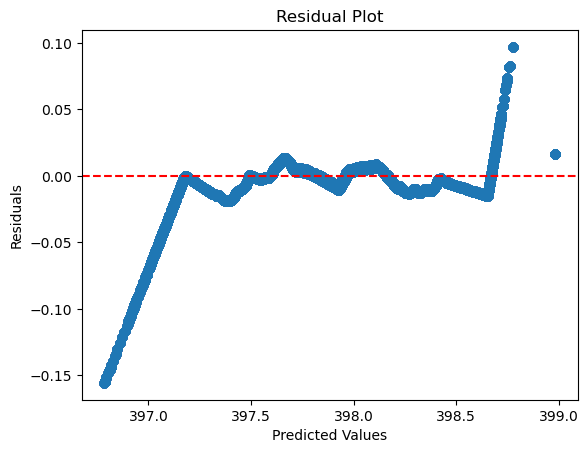

In [39]:
plt.scatter(Pre, Residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0 for reference
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [41]:
ana = pd.DataFrame({
    'node':node_df['Node_indicator'],
    'Predictions': Pre[0],
    'Residuals': residuals
})
ana.head()

,node,Predictions,Residuals
0,1.0,397.982842,0.006490
1,2.0,397.982202,0.006678
2,3.0,397.982566,0.006684
3,4.0,397.987157,0.008751
4,5.0,397.984281,0.006163


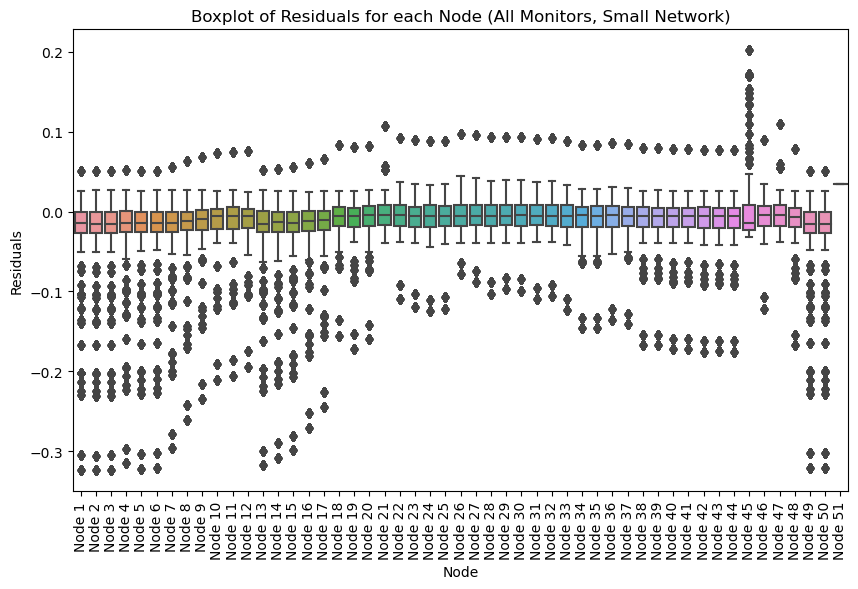

In [42]:
residuals_array =  np.array(residuals).reshape((-1, 51))
reshaped_ana = pd.DataFrame(residuals_array, columns=['Node ' + str(i+1) for i in range(51)])

plt.figure(figsize=(10, 6))  
sns.boxplot(data=reshaped_ana)
plt.xlabel('Node')
plt.ylabel('Residuals')
plt.title('Boxplot of Residuals for each Node (All Monitors, Small Network)')

plt.xticks(rotation=90)
plt.xticks(range(len(reshaped_ana.columns)), reshaped_ana.columns, rotation=90)

# Show the plot
plt.savefig('Boxplot of Residuals for each Node (All Monitors, Small Network).png')
plt.show()

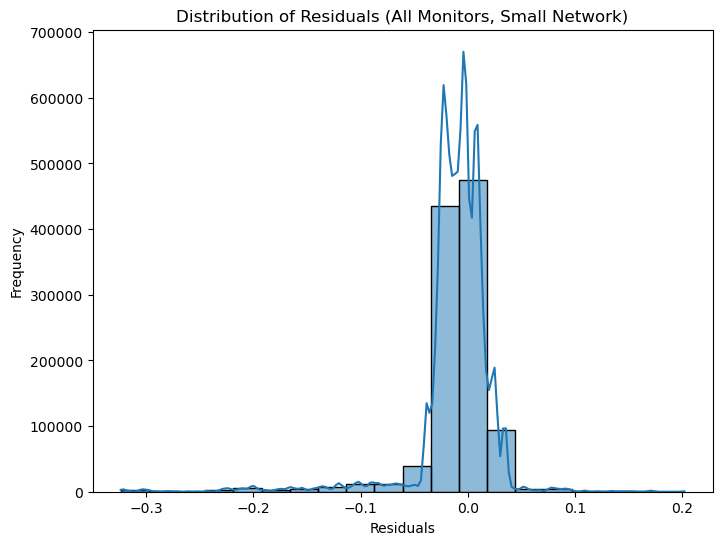

In [44]:
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
sns.histplot(residuals, kde=True, bins=20)  # kde=True adds a Kernel Density Estimation curve
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals (All Monitors, Small Network)')
plt.savefig('Distribution of Residuals (All Monitors, Small Network).png')
plt.show()

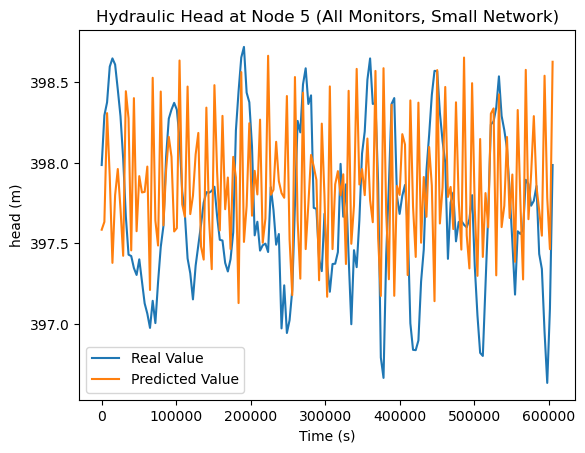

In [45]:
Pre_array =  np.array(Pre).reshape((-1, 51,128))
Pre_array = np.mean(Pre_array, axis=2)
Pre_ana = pd.DataFrame(Pre_array, columns=['Node ' + str(i+1) for i in range(51)])

head_at_node5 = head.loc[:,'5']
ax = head_at_node5.plot()
ax.set_xlabel("Time (s)")
ax.set_ylabel("head (m)")

Pre_ana = Pre_ana.set_index(head.index)

Pre_ana['Node 5'].plot(ax=ax)
plt.title('Hydraulic Head at Node 5 (All Monitors, Small Network)')
plt.legend(['Real Value', 'Predicted Value'])
plt.savefig('Hydraulic Head at Node 5 (All Monitors, Small Network).png')
plt.show()

In [46]:
residuals.max()

0.2017465231205957

In [47]:
residuals.min()

-0.323814201370201

In [24]:
Pre = pd.read_csv('Fully-S.csv')

In [8]:
results = wntr.sim.EpanetSimulator(wn).run_sim(version=2.0)
head = results.node['head']
demand = results.node['demand']
flow = results.link['flowrate']

In [26]:
Pre['0']

0          397.982842
1          397.982202
2          397.982566
3          397.987157
4          397.984281
              ...    
1103227    398.212787
1103228    398.092596
1103229    397.985256
1103230    397.985256
1103231    398.983626
Name: 0, Length: 1103232, dtype: float64

In [40]:
Pre_array =  np.array(Pre['0']).reshape((-1, 51,128))
Pre_array = np.mean(Pre_array, axis=2)
Pre_ana = pd.DataFrame(Pre_array, columns=['Node ' + str(i+1) for i in range(51)])

head_at_node5 = head.loc[:,'5']

In [37]:
Pre_ana = Pre_ana.set_index(head.index)
Pre_ana['Node 5'].iloc[24:48]

86400     397.957785
90000     398.161973
93600     398.038549
97200     397.574600
100800    397.594918
104400    398.636453
108000    397.742727
111600    397.665875
115200    398.474591
118800    397.682434
122400    397.796124
126000    398.052944
129600    398.186523
133200    397.481556
136800    397.399741
140400    398.343696
144000    397.649105
147600    397.340214
151200    398.483297
154800    397.944782
158400    397.580989
162000    398.292606
165600    397.712617
169200    397.909587
Name: Node 5, dtype: float64

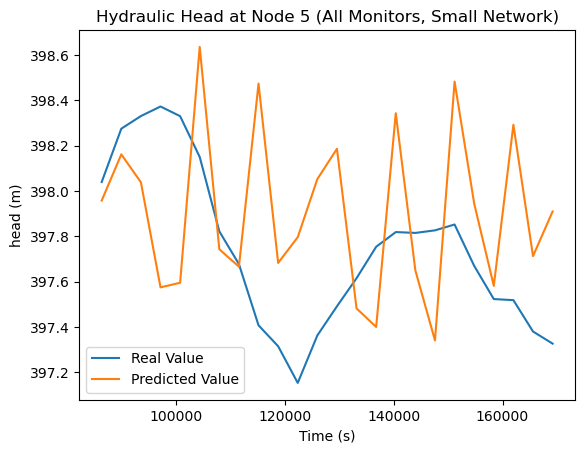

In [39]:
ax = head_at_node5.plot()
ax.set_xlabel("Time (s)")
ax.set_ylabel("head (m)")

Pre_ana = Pre_ana.set_index(head.index)

Pre_ana['Node 5'].iloc[24:48].plot(ax=ax)
plt.title('Hydraulic Head at Node 5 (All Monitors, Small Network)')
plt.legend(['Real Value', 'Predicted Value'])
plt.savefig('Hydraulic Head at Node 5 (All Monitors, Small Network, 24 Hours).png')
plt.show()

In [41]:
head_at_node5.min()

396.6336364746094

In [42]:
head_at_node5.max()

398.7208251953125

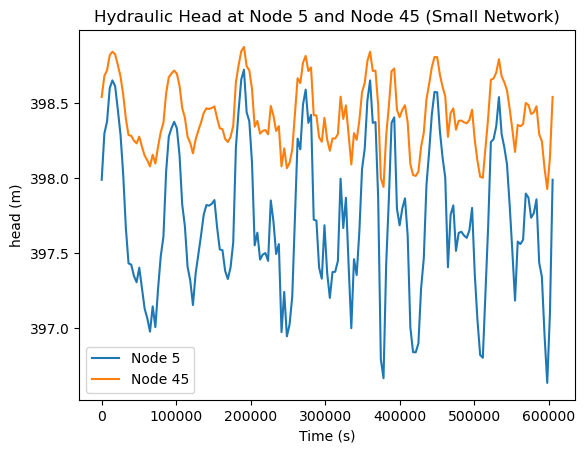

In [47]:
head_at_node5 = head.loc[:,'5']
head_at_node45 = head.loc[:,'45']
ax = head_at_node5.plot()
ax.set_xlabel("Time (s)")
ax.set_ylabel("head (m)")
head_at_node45.plot(ax=ax)
plt.title('Hydraulic Head at Node 5 and Node 45 (Small Network)')
plt.legend(['Node 5', 'Node 45'])
plt.savefig('Hydraulic Head at Node 5 and Node 45 (Small Network).png')
plt.show()

In [45]:
head.loc[:,'45'].min()

397.9254455566406

In [46]:
head.loc[:,'45'].max()

398.8724670410156